<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[01:24:53] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


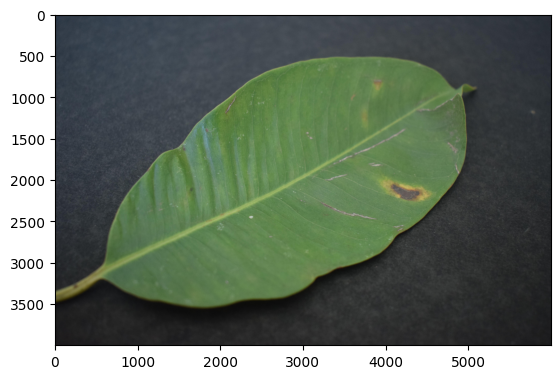

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

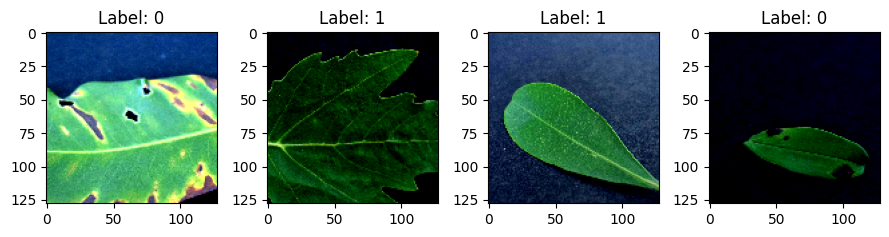

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[01:25:00] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

[01:25:02] /work/mxnet/src/operator/cudnn_ops.cc:421: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


[01:25:02] /work/mxnet/src/operator/cudnn_ops.cc:421: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


Epoch[1] Batch[5] Speed: 1.2094752082762017 samples/sec                   batch loss = 0.8946486115455627 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2525317770693851 samples/sec                   batch loss = 0.715431809425354 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.2502698437633675 samples/sec                   batch loss = 1.2139184474945068 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.249549290684904 samples/sec                   batch loss = 1.330371618270874 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2561324108387326 samples/sec                   batch loss = 0.9924310445785522 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2576777362422045 samples/sec                   batch loss = 0.6711029410362244 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.250056980912456 samples/sec                   batch loss = 0.3935161232948303 | accuracy = 0.6071428571428571


Epoch[1] Batch[40] Speed: 1.2539254079072892 samples/sec                   batch loss = 0.6774281859397888 | accuracy = 0.63125


Epoch[1] Batch[45] Speed: 1.265667382941042 samples/sec                   batch loss = 0.4509645402431488 | accuracy = 0.6277777777777778


Epoch[1] Batch[50] Speed: 1.2612228178483773 samples/sec                   batch loss = 0.6163473725318909 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.25978303507013 samples/sec                   batch loss = 0.7209182977676392 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.2590049928807137 samples/sec                   batch loss = 0.45505738258361816 | accuracy = 0.6083333333333333


Epoch[1] Batch[65] Speed: 1.2554264110868805 samples/sec                   batch loss = 1.1987841129302979 | accuracy = 0.6153846153846154


Epoch[1] Batch[70] Speed: 1.2582800956781557 samples/sec                   batch loss = 0.706019401550293 | accuracy = 0.6142857142857143


Epoch[1] Batch[75] Speed: 1.2537531776857076 samples/sec                   batch loss = 0.49340009689331055 | accuracy = 0.6166666666666667


Epoch[1] Batch[80] Speed: 1.2577621223632278 samples/sec                   batch loss = 0.3584567904472351 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.257918478754745 samples/sec                   batch loss = 0.7450965642929077 | accuracy = 0.6294117647058823


Epoch[1] Batch[90] Speed: 1.254832411312269 samples/sec                   batch loss = 0.4519902765750885 | accuracy = 0.6277777777777778


Epoch[1] Batch[95] Speed: 1.2551995806728238 samples/sec                   batch loss = 0.5869596600532532 | accuracy = 0.6342105263157894


Epoch[1] Batch[100] Speed: 1.2510486914677892 samples/sec                   batch loss = 0.26176637411117554 | accuracy = 0.64


Epoch[1] Batch[105] Speed: 1.256645089181554 samples/sec                   batch loss = 0.3798101246356964 | accuracy = 0.6428571428571429


Epoch[1] Batch[110] Speed: 1.2536545273890882 samples/sec                   batch loss = 0.2899395823478699 | accuracy = 0.6477272727272727


Epoch[1] Batch[115] Speed: 1.2575093749838382 samples/sec                   batch loss = 0.16547241806983948 | accuracy = 0.658695652173913


Epoch[1] Batch[120] Speed: 1.2538265430996671 samples/sec                   batch loss = 1.0631895065307617 | accuracy = 0.6541666666666667


Epoch[1] Batch[125] Speed: 1.257477706234894 samples/sec                   batch loss = 0.6659188866615295 | accuracy = 0.656


Epoch[1] Batch[130] Speed: 1.2543817937017492 samples/sec                   batch loss = 0.43466880917549133 | accuracy = 0.6538461538461539


Epoch[1] Batch[135] Speed: 1.2579621485509929 samples/sec                   batch loss = 0.18708443641662598 | accuracy = 0.6555555555555556


Epoch[1] Batch[140] Speed: 1.2580081796097924 samples/sec                   batch loss = 0.7568383812904358 | accuracy = 0.6535714285714286


Epoch[1] Batch[145] Speed: 1.2569334604759939 samples/sec                   batch loss = 0.6102699041366577 | accuracy = 0.6586206896551724


Epoch[1] Batch[150] Speed: 1.2542231272866458 samples/sec                   batch loss = 0.7128711342811584 | accuracy = 0.66


Epoch[1] Batch[155] Speed: 1.2599683754037092 samples/sec                   batch loss = 0.5697439312934875 | accuracy = 0.6629032258064517


Epoch[1] Batch[160] Speed: 1.259060359973908 samples/sec                   batch loss = 0.5102454423904419 | accuracy = 0.6625


Epoch[1] Batch[165] Speed: 1.2578278476666158 samples/sec                   batch loss = 0.3453787565231323 | accuracy = 0.6636363636363637


Epoch[1] Batch[170] Speed: 1.2550319760855042 samples/sec                   batch loss = 0.30261310935020447 | accuracy = 0.6617647058823529


Epoch[1] Batch[175] Speed: 1.257768157111865 samples/sec                   batch loss = 0.31089457869529724 | accuracy = 0.6657142857142857


Epoch[1] Batch[180] Speed: 1.2593705435243274 samples/sec                   batch loss = 0.5370045304298401 | accuracy = 0.6625


Epoch[1] Batch[185] Speed: 1.2652339498840475 samples/sec                   batch loss = 0.16903318464756012 | accuracy = 0.6635135135135135


Epoch[1] Batch[190] Speed: 1.254439005978491 samples/sec                   batch loss = 0.20440606772899628 | accuracy = 0.6644736842105263


Epoch[1] Batch[195] Speed: 1.2567680285685756 samples/sec                   batch loss = 0.4329149127006531 | accuracy = 0.6628205128205128


Epoch[1] Batch[200] Speed: 1.2560666745177622 samples/sec                   batch loss = 0.4615476429462433 | accuracy = 0.6625


Epoch[1] Batch[205] Speed: 1.2567547544749167 samples/sec                   batch loss = 0.5208989977836609 | accuracy = 0.6609756097560976


Epoch[1] Batch[210] Speed: 1.261930987547383 samples/sec                   batch loss = 0.3965013921260834 | accuracy = 0.6583333333333333


Epoch[1] Batch[215] Speed: 1.260867562211556 samples/sec                   batch loss = 0.24366581439971924 | accuracy = 0.6616279069767442


Epoch[1] Batch[220] Speed: 1.2584421501359089 samples/sec                   batch loss = 2.4047727584838867 | accuracy = 0.6636363636363637


Epoch[1] Batch[225] Speed: 1.2588075628622861 samples/sec                   batch loss = 0.35746192932128906 | accuracy = 0.6677777777777778


Epoch[1] Batch[230] Speed: 1.2527727984614174 samples/sec                   batch loss = 0.6212387681007385 | accuracy = 0.6663043478260869


Epoch[1] Batch[235] Speed: 1.2537033353295284 samples/sec                   batch loss = 1.0685369968414307 | accuracy = 0.6659574468085107


Epoch[1] Batch[240] Speed: 1.2528870284138156 samples/sec                   batch loss = 0.5241067409515381 | accuracy = 0.6666666666666666


Epoch[1] Batch[245] Speed: 1.2578418988737223 samples/sec                   batch loss = 0.809574544429779 | accuracy = 0.6673469387755102


Epoch[1] Batch[250] Speed: 1.2566055578895081 samples/sec                   batch loss = 0.5757331848144531 | accuracy = 0.669


Epoch[1] Batch[255] Speed: 1.2611835668626536 samples/sec                   batch loss = 0.8489612340927124 | accuracy = 0.6647058823529411


Epoch[1] Batch[260] Speed: 1.2560538854179464 samples/sec                   batch loss = 0.3527434766292572 | accuracy = 0.6653846153846154


Epoch[1] Batch[265] Speed: 1.2630216898616657 samples/sec                   batch loss = 0.4529598355293274 | accuracy = 0.6650943396226415


Epoch[1] Batch[270] Speed: 1.258395049051423 samples/sec                   batch loss = 0.6514775156974792 | accuracy = 0.6648148148148149


Epoch[1] Batch[275] Speed: 1.2548454571170296 samples/sec                   batch loss = 0.4368631839752197 | accuracy = 0.6645454545454546


Epoch[1] Batch[280] Speed: 1.2592324447716556 samples/sec                   batch loss = 0.4923084080219269 | accuracy = 0.6642857142857143


Epoch[1] Batch[285] Speed: 1.2552899273127878 samples/sec                   batch loss = 0.9999520182609558 | accuracy = 0.6649122807017543


Epoch[1] Batch[290] Speed: 1.2568961709398738 samples/sec                   batch loss = 1.1890711784362793 | accuracy = 0.6620689655172414


Epoch[1] Batch[295] Speed: 1.2551127211670985 samples/sec                   batch loss = 0.7537636756896973 | accuracy = 0.6601694915254237


Epoch[1] Batch[300] Speed: 1.261246236870676 samples/sec                   batch loss = 0.8091837167739868 | accuracy = 0.6591666666666667


Epoch[1] Batch[305] Speed: 1.2611924787078315 samples/sec                   batch loss = 1.0757343769073486 | accuracy = 0.6565573770491804


Epoch[1] Batch[310] Speed: 1.2539641146803695 samples/sec                   batch loss = 0.520529568195343 | accuracy = 0.6564516129032258


Epoch[1] Batch[315] Speed: 1.2568534225272998 samples/sec                   batch loss = 0.30272695422172546 | accuracy = 0.6579365079365079


Epoch[1] Batch[320] Speed: 1.2553861110005338 samples/sec                   batch loss = 0.3815951645374298 | accuracy = 0.65859375


Epoch[1] Batch[325] Speed: 1.2525360785397277 samples/sec                   batch loss = 0.41755813360214233 | accuracy = 0.6607692307692308


Epoch[1] Batch[330] Speed: 1.2544923775446288 samples/sec                   batch loss = 0.5407459735870361 | accuracy = 0.6606060606060606


Epoch[1] Batch[335] Speed: 1.257825961622445 samples/sec                   batch loss = 0.5997440218925476 | accuracy = 0.6619402985074627


Epoch[1] Batch[340] Speed: 1.261878974299729 samples/sec                   batch loss = 0.6288142204284668 | accuracy = 0.6602941176470588


Epoch[1] Batch[345] Speed: 1.2594964751518967 samples/sec                   batch loss = 0.7436380386352539 | accuracy = 0.6579710144927536


Epoch[1] Batch[350] Speed: 1.2516019507938845 samples/sec                   batch loss = 0.5851003527641296 | accuracy = 0.6557142857142857


Epoch[1] Batch[355] Speed: 1.2573402107316132 samples/sec                   batch loss = 0.6791660189628601 | accuracy = 0.6570422535211268


Epoch[1] Batch[360] Speed: 1.2575229477931196 samples/sec                   batch loss = 0.8414892554283142 | accuracy = 0.6569444444444444


Epoch[1] Batch[365] Speed: 1.2532719710830096 samples/sec                   batch loss = 0.322709321975708 | accuracy = 0.6582191780821918


Epoch[1] Batch[370] Speed: 1.2590129291616419 samples/sec                   batch loss = 0.8271729946136475 | accuracy = 0.6581081081081082


Epoch[1] Batch[375] Speed: 1.2536888143359117 samples/sec                   batch loss = 0.3898996412754059 | accuracy = 0.6593333333333333


Epoch[1] Batch[380] Speed: 1.2619771196722829 samples/sec                   batch loss = 0.16443590819835663 | accuracy = 0.6585526315789474


Epoch[1] Batch[385] Speed: 1.2569531419565587 samples/sec                   batch loss = 0.643121600151062 | accuracy = 0.6571428571428571


Epoch[1] Batch[390] Speed: 1.2546374135583003 samples/sec                   batch loss = 0.609272301197052 | accuracy = 0.6576923076923077


Epoch[1] Batch[395] Speed: 1.2545744604322464 samples/sec                   batch loss = 0.4991946816444397 | accuracy = 0.6582278481012658


Epoch[1] Batch[400] Speed: 1.2605042673421727 samples/sec                   batch loss = 0.5915560722351074 | accuracy = 0.6575


Epoch[1] Batch[405] Speed: 1.2546629343598448 samples/sec                   batch loss = 0.6265003085136414 | accuracy = 0.658641975308642


Epoch[1] Batch[410] Speed: 1.2491778851974364 samples/sec                   batch loss = 0.7099711894989014 | accuracy = 0.6573170731707317


Epoch[1] Batch[415] Speed: 1.2479586947875392 samples/sec                   batch loss = 1.056666612625122 | accuracy = 0.6578313253012048


Epoch[1] Batch[420] Speed: 1.2538723657024098 samples/sec                   batch loss = 1.3171554803848267 | accuracy = 0.656547619047619


Epoch[1] Batch[425] Speed: 1.2599346903084054 samples/sec                   batch loss = 0.46549272537231445 | accuracy = 0.658235294117647


Epoch[1] Batch[430] Speed: 1.2551031438818043 samples/sec                   batch loss = 0.788870096206665 | accuracy = 0.6563953488372093


Epoch[1] Batch[435] Speed: 1.2514350254975577 samples/sec                   batch loss = 0.6447353363037109 | accuracy = 0.6563218390804598


Epoch[1] Batch[440] Speed: 1.2603929051693699 samples/sec                   batch loss = 0.5047776699066162 | accuracy = 0.6590909090909091


Epoch[1] Batch[445] Speed: 1.2591398287660927 samples/sec                   batch loss = 0.46104633808135986 | accuracy = 0.6595505617977528


Epoch[1] Batch[450] Speed: 1.2580808174353044 samples/sec                   batch loss = 0.47700342535972595 | accuracy = 0.6611111111111111


Epoch[1] Batch[455] Speed: 1.2607603044993392 samples/sec                   batch loss = 0.36822575330734253 | accuracy = 0.6615384615384615


Epoch[1] Batch[460] Speed: 1.2568603901318738 samples/sec                   batch loss = 0.6042267084121704 | accuracy = 0.6630434782608695


Epoch[1] Batch[465] Speed: 1.2547563943924471 samples/sec                   batch loss = 0.32447725534439087 | accuracy = 0.6645161290322581


Epoch[1] Batch[470] Speed: 1.261247469474889 samples/sec                   batch loss = 0.44417253136634827 | accuracy = 0.6654255319148936


Epoch[1] Batch[475] Speed: 1.258114403473452 samples/sec                   batch loss = 0.7774940133094788 | accuracy = 0.6663157894736842


Epoch[1] Batch[480] Speed: 1.2608567598134495 samples/sec                   batch loss = 0.744435727596283 | accuracy = 0.6661458333333333


Epoch[1] Batch[485] Speed: 1.2605076766987071 samples/sec                   batch loss = 0.5183813571929932 | accuracy = 0.6664948453608247


Epoch[1] Batch[490] Speed: 1.2555156629118922 samples/sec                   batch loss = 0.4349885582923889 | accuracy = 0.6663265306122449


Epoch[1] Batch[495] Speed: 1.261665366314036 samples/sec                   batch loss = 0.33297401666641235 | accuracy = 0.6671717171717172


Epoch[1] Batch[500] Speed: 1.2612351435411753 samples/sec                   batch loss = 0.686705470085144 | accuracy = 0.668


Epoch[1] Batch[505] Speed: 1.2566615612873226 samples/sec                   batch loss = 0.44276300072669983 | accuracy = 0.6693069306930693


Epoch[1] Batch[510] Speed: 1.2566204288932543 samples/sec                   batch loss = 0.32376354932785034 | accuracy = 0.6696078431372549


Epoch[1] Batch[515] Speed: 1.259870258388351 samples/sec                   batch loss = 0.8928731679916382 | accuracy = 0.670388349514563


Epoch[1] Batch[520] Speed: 1.251388820826804 samples/sec                   batch loss = 0.07858961075544357 | accuracy = 0.6706730769230769


Epoch[1] Batch[525] Speed: 1.2580210085378913 samples/sec                   batch loss = 0.4896886944770813 | accuracy = 0.6704761904761904


Epoch[1] Batch[530] Speed: 1.2572324217160518 samples/sec                   batch loss = 0.37108534574508667 | accuracy = 0.6702830188679245


Epoch[1] Batch[535] Speed: 1.261751332222136 samples/sec                   batch loss = 0.7737236618995667 | accuracy = 0.6705607476635514


Epoch[1] Batch[540] Speed: 1.2631891527804486 samples/sec                   batch loss = 0.5437010526657104 | accuracy = 0.6708333333333333


Epoch[1] Batch[545] Speed: 1.2578480286932907 samples/sec                   batch loss = 0.5805549025535583 | accuracy = 0.6697247706422018


Epoch[1] Batch[550] Speed: 1.2603287104096839 samples/sec                   batch loss = 0.3089067339897156 | accuracy = 0.6709090909090909


Epoch[1] Batch[555] Speed: 1.2559413337645267 samples/sec                   batch loss = 0.352962464094162 | accuracy = 0.6711711711711712


Epoch[1] Batch[560] Speed: 1.2589822238681256 samples/sec                   batch loss = 0.22497044503688812 | accuracy = 0.6714285714285714


Epoch[1] Batch[565] Speed: 1.2553630969604173 samples/sec                   batch loss = 0.21176835894584656 | accuracy = 0.6721238938053097


Epoch[1] Batch[570] Speed: 1.2595191682130493 samples/sec                   batch loss = 1.3998006582260132 | accuracy = 0.6719298245614035


Epoch[1] Batch[575] Speed: 1.2590263454831276 samples/sec                   batch loss = 0.20595310628414154 | accuracy = 0.6717391304347826


Epoch[1] Batch[580] Speed: 1.2531377337269347 samples/sec                   batch loss = 0.19485586881637573 | accuracy = 0.6732758620689655


Epoch[1] Batch[585] Speed: 1.2559141626621833 samples/sec                   batch loss = 1.0756149291992188 | accuracy = 0.6743589743589744


Epoch[1] Batch[590] Speed: 1.2584186463484088 samples/sec                   batch loss = 0.5543620586395264 | accuracy = 0.6758474576271186


Epoch[1] Batch[595] Speed: 1.260029221306409 samples/sec                   batch loss = 0.7016157507896423 | accuracy = 0.6743697478991597


Epoch[1] Batch[600] Speed: 1.2584112838967658 samples/sec                   batch loss = 0.7444646954536438 | accuracy = 0.6741666666666667


Epoch[1] Batch[605] Speed: 1.2545307440945765 samples/sec                   batch loss = 1.2177116870880127 | accuracy = 0.6739669421487603


Epoch[1] Batch[610] Speed: 1.2582364981682421 samples/sec                   batch loss = 0.37278103828430176 | accuracy = 0.6733606557377049


Epoch[1] Batch[615] Speed: 1.2579721468142642 samples/sec                   batch loss = 0.6641923189163208 | accuracy = 0.6731707317073171


Epoch[1] Batch[620] Speed: 1.2567913765909609 samples/sec                   batch loss = 0.6187570691108704 | accuracy = 0.6737903225806452


Epoch[1] Batch[625] Speed: 1.2560609381981354 samples/sec                   batch loss = 0.32316815853118896 | accuracy = 0.6744


Epoch[1] Batch[630] Speed: 1.2559122823525748 samples/sec                   batch loss = 0.9970830678939819 | accuracy = 0.6738095238095239


Epoch[1] Batch[635] Speed: 1.2527484770009332 samples/sec                   batch loss = 0.28760549426078796 | accuracy = 0.6740157480314961


Epoch[1] Batch[640] Speed: 1.2536444102877173 samples/sec                   batch loss = 0.652302622795105 | accuracy = 0.674609375


Epoch[1] Batch[645] Speed: 1.2554138229032514 samples/sec                   batch loss = 0.7112642526626587 | accuracy = 0.6748062015503876


Epoch[1] Batch[650] Speed: 1.2574620609535587 samples/sec                   batch loss = 0.4668523371219635 | accuracy = 0.6753846153846154


Epoch[1] Batch[655] Speed: 1.254258007949637 samples/sec                   batch loss = 0.4299537241458893 | accuracy = 0.6755725190839694


Epoch[1] Batch[660] Speed: 1.255212634113258 samples/sec                   batch loss = 0.9117534756660461 | accuracy = 0.6765151515151515


Epoch[1] Batch[665] Speed: 1.257771551683422 samples/sec                   batch loss = 0.6813418865203857 | accuracy = 0.6774436090225564


Epoch[1] Batch[670] Speed: 1.2509357291857808 samples/sec                   batch loss = 0.6244080066680908 | accuracy = 0.6779850746268656


Epoch[1] Batch[675] Speed: 1.2582211170837785 samples/sec                   batch loss = 0.6668765544891357 | accuracy = 0.6777777777777778


Epoch[1] Batch[680] Speed: 1.2550192080472198 samples/sec                   batch loss = 0.9651894569396973 | accuracy = 0.6779411764705883


Epoch[1] Batch[685] Speed: 1.2565764757412035 samples/sec                   batch loss = 0.6850987672805786 | accuracy = 0.6773722627737226


Epoch[1] Batch[690] Speed: 1.2548731451553972 samples/sec                   batch loss = 0.34183651208877563 | accuracy = 0.678623188405797


Epoch[1] Batch[695] Speed: 1.257981390633022 samples/sec                   batch loss = 0.1967257261276245 | accuracy = 0.6776978417266187


Epoch[1] Batch[700] Speed: 1.2607159665363386 samples/sec                   batch loss = 0.39642879366874695 | accuracy = 0.6792857142857143


Epoch[1] Batch[705] Speed: 1.265100572202365 samples/sec                   batch loss = 0.6225217580795288 | accuracy = 0.6794326241134752


Epoch[1] Batch[710] Speed: 1.2579817679346323 samples/sec                   batch loss = 0.291201114654541 | accuracy = 0.6809859154929577


Epoch[1] Batch[715] Speed: 1.2576006200595098 samples/sec                   batch loss = 0.322167307138443 | accuracy = 0.6807692307692308


Epoch[1] Batch[720] Speed: 1.2561983421570078 samples/sec                   batch loss = 0.3133390545845032 | accuracy = 0.6822916666666666


Epoch[1] Batch[725] Speed: 1.2566229701759428 samples/sec                   batch loss = 1.2970517873764038 | accuracy = 0.6817241379310345


Epoch[1] Batch[730] Speed: 1.2577916366067308 samples/sec                   batch loss = 0.6946151852607727 | accuracy = 0.6821917808219178


Epoch[1] Batch[735] Speed: 1.2574916553682256 samples/sec                   batch loss = 0.31625884771347046 | accuracy = 0.6819727891156463


Epoch[1] Batch[740] Speed: 1.2551341297450989 samples/sec                   batch loss = 0.1379917711019516 | accuracy = 0.6827702702702703


Epoch[1] Batch[745] Speed: 1.2547019681822686 samples/sec                   batch loss = 0.3315030038356781 | accuracy = 0.6828859060402684


Epoch[1] Batch[750] Speed: 1.2515932673399983 samples/sec                   batch loss = 0.6848659515380859 | accuracy = 0.6833333333333333


Epoch[1] Batch[755] Speed: 1.2544753056533808 samples/sec                   batch loss = 0.2777027487754822 | accuracy = 0.6841059602649007


Epoch[1] Batch[760] Speed: 1.2559480091979396 samples/sec                   batch loss = 0.19758139550685883 | accuracy = 0.6842105263157895


Epoch[1] Batch[765] Speed: 1.2537870015416368 samples/sec                   batch loss = 0.7407524585723877 | accuracy = 0.6849673202614379


Epoch[1] Batch[770] Speed: 1.2512570395820077 samples/sec                   batch loss = 1.6041826009750366 | accuracy = 0.685064935064935


Epoch[1] Batch[775] Speed: 1.2577724946232174 samples/sec                   batch loss = 0.21234939992427826 | accuracy = 0.6854838709677419


Epoch[1] Batch[780] Speed: 1.2530577104927985 samples/sec                   batch loss = 0.4312506914138794 | accuracy = 0.6855769230769231


Epoch[1] Batch[785] Speed: 1.2485686892593888 samples/sec                   batch loss = 0.28475242853164673 | accuracy = 0.6859872611464968


[Epoch 1] training: accuracy=0.6865482233502538
[Epoch 1] time cost: 646.671017408371
[Epoch 1] validation: validation accuracy=0.7644444444444445


Epoch[2] Batch[5] Speed: 1.2558296483063547 samples/sec                   batch loss = 0.18339750170707703 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2607668417705005 samples/sec                   batch loss = 0.30458471179008484 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.2555370852382486 samples/sec                   batch loss = 0.4829060733318329 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2588524278836613 samples/sec                   batch loss = 0.8271627426147461 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2568147254808733 samples/sec                   batch loss = 0.4423753023147583 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2597228750474914 samples/sec                   batch loss = 1.4454216957092285 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2580777042135949 samples/sec                   batch loss = 0.5120770931243896 | accuracy = 0.75


Epoch[2] Batch[40] Speed: 1.2586435257889566 samples/sec                   batch loss = 0.39711442589759827 | accuracy = 0.7625


Epoch[2] Batch[45] Speed: 1.2593505026753253 samples/sec                   batch loss = 0.2529049515724182 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2604665762406049 samples/sec                   batch loss = 0.4544322192668915 | accuracy = 0.74


Epoch[2] Batch[55] Speed: 1.2523276782127348 samples/sec                   batch loss = 0.3910548686981201 | accuracy = 0.7454545454545455


Epoch[2] Batch[60] Speed: 1.2576665170409858 samples/sec                   batch loss = 0.4778536260128021 | accuracy = 0.7333333333333333


Epoch[2] Batch[65] Speed: 1.2552733972257297 samples/sec                   batch loss = 0.3742055296897888 | accuracy = 0.7461538461538462


Epoch[2] Batch[70] Speed: 1.2553871443037607 samples/sec                   batch loss = 0.25441986322402954 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2627208246528823 samples/sec                   batch loss = 0.4777924120426178 | accuracy = 0.7533333333333333


Epoch[2] Batch[80] Speed: 1.2572678468360678 samples/sec                   batch loss = 0.6392672657966614 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.2593175122895781 samples/sec                   batch loss = 0.44576403498649597 | accuracy = 0.7588235294117647


Epoch[2] Batch[90] Speed: 1.2610271560434307 samples/sec                   batch loss = 1.0588587522506714 | accuracy = 0.7555555555555555


Epoch[2] Batch[95] Speed: 1.2604862738215465 samples/sec                   batch loss = 0.23690365254878998 | accuracy = 0.7552631578947369


Epoch[2] Batch[100] Speed: 1.2626812903101503 samples/sec                   batch loss = 0.9404551386833191 | accuracy = 0.7475


Epoch[2] Batch[105] Speed: 1.260788443670378 samples/sec                   batch loss = 0.28834500908851624 | accuracy = 0.75


Epoch[2] Batch[110] Speed: 1.2583074636239673 samples/sec                   batch loss = 0.5393657088279724 | accuracy = 0.7545454545454545


Epoch[2] Batch[115] Speed: 1.2592793250043477 samples/sec                   batch loss = 0.7605298161506653 | accuracy = 0.7521739130434782


Epoch[2] Batch[120] Speed: 1.2576937640197465 samples/sec                   batch loss = 0.28566932678222656 | accuracy = 0.7520833333333333


Epoch[2] Batch[125] Speed: 1.257231479585857 samples/sec                   batch loss = 0.616927981376648 | accuracy = 0.754


Epoch[2] Batch[130] Speed: 1.2587936789668015 samples/sec                   batch loss = 0.5888569951057434 | accuracy = 0.7538461538461538


Epoch[2] Batch[135] Speed: 1.2566582668316224 samples/sec                   batch loss = 0.25657621026039124 | accuracy = 0.7555555555555555


Epoch[2] Batch[140] Speed: 1.2593619410062922 samples/sec                   batch loss = 0.1320473849773407 | accuracy = 0.7535714285714286


Epoch[2] Batch[145] Speed: 1.2589106154955891 samples/sec                   batch loss = 0.9257393479347229 | accuracy = 0.7517241379310344


Epoch[2] Batch[150] Speed: 1.258332662061215 samples/sec                   batch loss = 0.7331487536430359 | accuracy = 0.7516666666666667


Epoch[2] Batch[155] Speed: 1.2598283480631807 samples/sec                   batch loss = 0.13664911687374115 | accuracy = 0.7516129032258064


Epoch[2] Batch[160] Speed: 1.2564239341596504 samples/sec                   batch loss = 0.33907896280288696 | accuracy = 0.7515625


Epoch[2] Batch[165] Speed: 1.2604807811649617 samples/sec                   batch loss = 0.21885526180267334 | accuracy = 0.7515151515151515


Epoch[2] Batch[170] Speed: 1.2572520183442375 samples/sec                   batch loss = 0.21169845759868622 | accuracy = 0.7514705882352941


Epoch[2] Batch[175] Speed: 1.262631400742698 samples/sec                   batch loss = 0.1914394348859787 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.2588041626962987 samples/sec                   batch loss = 0.2655162215232849 | accuracy = 0.7569444444444444


Epoch[2] Batch[185] Speed: 1.2597953326374025 samples/sec                   batch loss = 0.37275657057762146 | accuracy = 0.7581081081081081


Epoch[2] Batch[190] Speed: 1.2615829221605013 samples/sec                   batch loss = 0.426242470741272 | accuracy = 0.7578947368421053


Epoch[2] Batch[195] Speed: 1.25853466353066 samples/sec                   batch loss = 0.4779931604862213 | accuracy = 0.7538461538461538


Epoch[2] Batch[200] Speed: 1.2584476250397925 samples/sec                   batch loss = 0.20349042117595673 | accuracy = 0.75875


Epoch[2] Batch[205] Speed: 1.2555540920792672 samples/sec                   batch loss = 0.2419997602701187 | accuracy = 0.7560975609756098


Epoch[2] Batch[210] Speed: 1.257322967016175 samples/sec                   batch loss = 0.2783071994781494 | accuracy = 0.7559523809523809


Epoch[2] Batch[215] Speed: 1.258320676161839 samples/sec                   batch loss = 0.48919516801834106 | accuracy = 0.7558139534883721


Epoch[2] Batch[220] Speed: 1.2614535378740965 samples/sec                   batch loss = 0.3060440719127655 | accuracy = 0.7602272727272728


Epoch[2] Batch[225] Speed: 1.2591651550549947 samples/sec                   batch loss = 0.2102556973695755 | accuracy = 0.7577777777777778


Epoch[2] Batch[230] Speed: 1.2574295464033272 samples/sec                   batch loss = 0.1689767837524414 | accuracy = 0.7597826086956522


Epoch[2] Batch[235] Speed: 1.2594534551347347 samples/sec                   batch loss = 0.19581563770771027 | accuracy = 0.7585106382978724


Epoch[2] Batch[240] Speed: 1.25932876096616 samples/sec                   batch loss = 0.07194840162992477 | accuracy = 0.7572916666666667


Epoch[2] Batch[245] Speed: 1.256564899726633 samples/sec                   batch loss = 0.2636943757534027 | accuracy = 0.7591836734693878


Epoch[2] Batch[250] Speed: 1.2579597904931945 samples/sec                   batch loss = 0.7458643913269043 | accuracy = 0.759


Epoch[2] Batch[255] Speed: 1.2573821441443374 samples/sec                   batch loss = 0.9508602023124695 | accuracy = 0.7578431372549019


Epoch[2] Batch[260] Speed: 1.2538271990233172 samples/sec                   batch loss = 0.380630224943161 | accuracy = 0.7596153846153846


Epoch[2] Batch[265] Speed: 1.254111090969911 samples/sec                   batch loss = 0.28281038999557495 | accuracy = 0.7575471698113208


Epoch[2] Batch[270] Speed: 1.2614394058611929 samples/sec                   batch loss = 1.314603567123413 | accuracy = 0.7574074074074074


Epoch[2] Batch[275] Speed: 1.263586734054079 samples/sec                   batch loss = 0.24300628900527954 | accuracy = 0.759090909090909


Epoch[2] Batch[280] Speed: 1.2611614774064293 samples/sec                   batch loss = 2.6359310150146484 | accuracy = 0.7553571428571428


Epoch[2] Batch[285] Speed: 1.2602211657042177 samples/sec                   batch loss = 0.2676393389701843 | accuracy = 0.756140350877193


Epoch[2] Batch[290] Speed: 1.263303482898749 samples/sec                   batch loss = 0.2976229786872864 | accuracy = 0.7551724137931034


Epoch[2] Batch[295] Speed: 1.260747988085683 samples/sec                   batch loss = 0.42395544052124023 | accuracy = 0.7567796610169492


Epoch[2] Batch[300] Speed: 1.2648649879369305 samples/sec                   batch loss = 0.7860664129257202 | accuracy = 0.7566666666666667


Epoch[2] Batch[305] Speed: 1.26642835041924 samples/sec                   batch loss = 0.4435337781906128 | accuracy = 0.7573770491803279


Epoch[2] Batch[310] Speed: 1.2661320710362112 samples/sec                   batch loss = 0.6711947917938232 | accuracy = 0.7524193548387097


Epoch[2] Batch[315] Speed: 1.2620306599469557 samples/sec                   batch loss = 0.3077999949455261 | accuracy = 0.7531746031746032


Epoch[2] Batch[320] Speed: 1.2617177414994205 samples/sec                   batch loss = 0.2644447684288025 | accuracy = 0.75234375


Epoch[2] Batch[325] Speed: 1.2596504257919507 samples/sec                   batch loss = 0.3218878507614136 | accuracy = 0.7530769230769231


Epoch[2] Batch[330] Speed: 1.2612233867212035 samples/sec                   batch loss = 0.6277299523353577 | accuracy = 0.7515151515151515


Epoch[2] Batch[335] Speed: 1.2654198478061272 samples/sec                   batch loss = 0.26737016439437866 | accuracy = 0.753731343283582


Epoch[2] Batch[340] Speed: 1.2600717128320245 samples/sec                   batch loss = 0.4866916239261627 | accuracy = 0.7536764705882353


Epoch[2] Batch[345] Speed: 1.257968751159859 samples/sec                   batch loss = 0.5557121634483337 | accuracy = 0.7543478260869565


Epoch[2] Batch[350] Speed: 1.2634738750750172 samples/sec                   batch loss = 0.5979408621788025 | accuracy = 0.7528571428571429


Epoch[2] Batch[355] Speed: 1.260521314309276 samples/sec                   batch loss = 0.4493159055709839 | accuracy = 0.7535211267605634


Epoch[2] Batch[360] Speed: 1.2615770404807842 samples/sec                   batch loss = 0.20681031048297882 | accuracy = 0.7555555555555555


Epoch[2] Batch[365] Speed: 1.2573305994220416 samples/sec                   batch loss = 0.22308968007564545 | accuracy = 0.7534246575342466


Epoch[2] Batch[370] Speed: 1.2538899834635437 samples/sec                   batch loss = 1.048492193222046 | accuracy = 0.7527027027027027


Epoch[2] Batch[375] Speed: 1.259738765815799 samples/sec                   batch loss = 0.6793473958969116 | accuracy = 0.7486666666666667


Epoch[2] Batch[380] Speed: 1.2604713111798167 samples/sec                   batch loss = 0.5970283150672913 | accuracy = 0.7480263157894737


Epoch[2] Batch[385] Speed: 1.2658733700779214 samples/sec                   batch loss = 0.26534175872802734 | accuracy = 0.7487012987012988


Epoch[2] Batch[390] Speed: 1.261487588789665 samples/sec                   batch loss = 0.4227983057498932 | accuracy = 0.7487179487179487


Epoch[2] Batch[395] Speed: 1.2622582568059462 samples/sec                   batch loss = 0.41866710782051086 | accuracy = 0.7512658227848101


Epoch[2] Batch[400] Speed: 1.2575662130781604 samples/sec                   batch loss = 0.5212681293487549 | accuracy = 0.75


Epoch[2] Batch[405] Speed: 1.2579131027691353 samples/sec                   batch loss = 0.19844530522823334 | accuracy = 0.7506172839506173


Epoch[2] Batch[410] Speed: 1.2635104140550977 samples/sec                   batch loss = 0.4094090461730957 | accuracy = 0.75


Epoch[2] Batch[415] Speed: 1.2628432447600622 samples/sec                   batch loss = 0.6479608416557312 | accuracy = 0.75


Epoch[2] Batch[420] Speed: 1.2649123838733853 samples/sec                   batch loss = 0.3476528227329254 | accuracy = 0.7488095238095238


Epoch[2] Batch[425] Speed: 1.254317834679195 samples/sec                   batch loss = 0.3960224688053131 | accuracy = 0.7494117647058823


Epoch[2] Batch[430] Speed: 1.2552971593627749 samples/sec                   batch loss = 1.1282087564468384 | accuracy = 0.7488372093023256


Epoch[2] Batch[435] Speed: 1.2593241291338189 samples/sec                   batch loss = 0.5339330434799194 | accuracy = 0.75


Epoch[2] Batch[440] Speed: 1.2599223900202996 samples/sec                   batch loss = 0.4330596923828125 | accuracy = 0.7511363636363636


Epoch[2] Batch[445] Speed: 1.2513933944703401 samples/sec                   batch loss = 0.18077600002288818 | accuracy = 0.7539325842696629


Epoch[2] Batch[450] Speed: 1.2537524281472427 samples/sec                   batch loss = 0.1473374217748642 | accuracy = 0.7555555555555555


Epoch[2] Batch[455] Speed: 1.2540395669541768 samples/sec                   batch loss = 0.7678239345550537 | accuracy = 0.7538461538461538


Epoch[2] Batch[460] Speed: 1.2548533410442082 samples/sec                   batch loss = 0.34159019589424133 | accuracy = 0.7554347826086957


Epoch[2] Batch[465] Speed: 1.256998439954429 samples/sec                   batch loss = 0.030263230204582214 | accuracy = 0.7575268817204301


Epoch[2] Batch[470] Speed: 1.25665572540617 samples/sec                   batch loss = 0.2530921995639801 | accuracy = 0.7569148936170212


Epoch[2] Batch[475] Speed: 1.2563036020711633 samples/sec                   batch loss = 0.40490850806236267 | accuracy = 0.7563157894736842


Epoch[2] Batch[480] Speed: 1.2604124110672055 samples/sec                   batch loss = 0.5530958771705627 | accuracy = 0.75625


Epoch[2] Batch[485] Speed: 1.2538967308223234 samples/sec                   batch loss = 0.26859432458877563 | accuracy = 0.7572164948453608


Epoch[2] Batch[490] Speed: 1.2577680628184722 samples/sec                   batch loss = 0.2706452012062073 | accuracy = 0.7556122448979592


Epoch[2] Batch[495] Speed: 1.2594824815051315 samples/sec                   batch loss = 0.43799901008605957 | accuracy = 0.7570707070707071


Epoch[2] Batch[500] Speed: 1.256651301467867 samples/sec                   batch loss = 0.497590035200119 | accuracy = 0.756


Epoch[2] Batch[505] Speed: 1.257911310784143 samples/sec                   batch loss = 0.15296950936317444 | accuracy = 0.7564356435643564


Epoch[2] Batch[510] Speed: 1.2562165897075128 samples/sec                   batch loss = 0.5471617579460144 | accuracy = 0.7558823529411764


Epoch[2] Batch[515] Speed: 1.2562932540234637 samples/sec                   batch loss = 0.26938995718955994 | accuracy = 0.7567961165048543


Epoch[2] Batch[520] Speed: 1.2568407115558111 samples/sec                   batch loss = 0.3936767280101776 | accuracy = 0.75625


Epoch[2] Batch[525] Speed: 1.2485700830474096 samples/sec                   batch loss = 0.2390352338552475 | accuracy = 0.7571428571428571


Epoch[2] Batch[530] Speed: 1.2546426677560987 samples/sec                   batch loss = 0.3204687237739563 | accuracy = 0.7566037735849057


Epoch[2] Batch[535] Speed: 1.2620542988542511 samples/sec                   batch loss = 1.0941858291625977 | accuracy = 0.7574766355140187


Epoch[2] Batch[540] Speed: 1.2566594904845803 samples/sec                   batch loss = 0.27888843417167664 | accuracy = 0.7574074074074074


Epoch[2] Batch[545] Speed: 1.2520944904596285 samples/sec                   batch loss = 0.6460736393928528 | accuracy = 0.7568807339449541


Epoch[2] Batch[550] Speed: 1.2556261648557479 samples/sec                   batch loss = 0.4329454302787781 | accuracy = 0.7563636363636363


Epoch[2] Batch[555] Speed: 1.2517938578652896 samples/sec                   batch loss = 0.24152816832065582 | accuracy = 0.7572072072072072


Epoch[2] Batch[560] Speed: 1.2573526491150682 samples/sec                   batch loss = 0.13197359442710876 | accuracy = 0.7575892857142857


Epoch[2] Batch[565] Speed: 1.2615348268083189 samples/sec                   batch loss = 0.13147814571857452 | accuracy = 0.7588495575221239


Epoch[2] Batch[570] Speed: 1.2606899147007011 samples/sec                   batch loss = 0.29318124055862427 | accuracy = 0.7592105263157894


Epoch[2] Batch[575] Speed: 1.2582207396385803 samples/sec                   batch loss = 0.6722040176391602 | accuracy = 0.7591304347826087


Epoch[2] Batch[580] Speed: 1.259415921388596 samples/sec                   batch loss = 0.1287207156419754 | accuracy = 0.7586206896551724


Epoch[2] Batch[585] Speed: 1.2568243289051266 samples/sec                   batch loss = 0.5849408507347107 | accuracy = 0.7572649572649572


Epoch[2] Batch[590] Speed: 1.2599224846369836 samples/sec                   batch loss = 0.4599897563457489 | accuracy = 0.7576271186440678


Epoch[2] Batch[595] Speed: 1.2601727955052888 samples/sec                   batch loss = 0.6214470863342285 | accuracy = 0.7584033613445378


Epoch[2] Batch[600] Speed: 1.25981321183655 samples/sec                   batch loss = 0.830505907535553 | accuracy = 0.7558333333333334


Epoch[2] Batch[605] Speed: 1.2603399771583692 samples/sec                   batch loss = 0.2462722212076187 | accuracy = 0.7557851239669422


Epoch[2] Batch[610] Speed: 1.2605341945457746 samples/sec                   batch loss = 0.3044840395450592 | accuracy = 0.7553278688524591


Epoch[2] Batch[615] Speed: 1.26564370396947 samples/sec                   batch loss = 0.13677074015140533 | accuracy = 0.7556910569105691


Epoch[2] Batch[620] Speed: 1.256666832452372 samples/sec                   batch loss = 0.5176256895065308 | accuracy = 0.7556451612903226


Epoch[2] Batch[625] Speed: 1.259141340754744 samples/sec                   batch loss = 0.09790021926164627 | accuracy = 0.7564


Epoch[2] Batch[630] Speed: 1.2583782483153272 samples/sec                   batch loss = 0.5038169622421265 | accuracy = 0.7563492063492063


Epoch[2] Batch[635] Speed: 1.2565555826015316 samples/sec                   batch loss = 0.2728288769721985 | accuracy = 0.7562992125984253


Epoch[2] Batch[640] Speed: 1.2595544386353683 samples/sec                   batch loss = 0.4914361536502838 | accuracy = 0.75703125


Epoch[2] Batch[645] Speed: 1.25988634209773 samples/sec                   batch loss = 0.2587648332118988 | accuracy = 0.7581395348837209


Epoch[2] Batch[650] Speed: 1.2584992613903894 samples/sec                   batch loss = 0.392534077167511 | accuracy = 0.7580769230769231


Epoch[2] Batch[655] Speed: 1.2594024967631439 samples/sec                   batch loss = 0.7154847979545593 | accuracy = 0.7576335877862596


Epoch[2] Batch[660] Speed: 1.2564657123781287 samples/sec                   batch loss = 0.4397771656513214 | accuracy = 0.7583333333333333


Epoch[2] Batch[665] Speed: 1.26324545920418 samples/sec                   batch loss = 0.5614414811134338 | accuracy = 0.7567669172932331


Epoch[2] Batch[670] Speed: 1.2613066373104842 samples/sec                   batch loss = 0.44550132751464844 | accuracy = 0.7567164179104477


Epoch[2] Batch[675] Speed: 1.2569991933790854 samples/sec                   batch loss = 0.49533766508102417 | accuracy = 0.7570370370370371


Epoch[2] Batch[680] Speed: 1.2579440388938663 samples/sec                   batch loss = 0.43000584840774536 | accuracy = 0.7573529411764706


Epoch[2] Batch[685] Speed: 1.2589243130370262 samples/sec                   batch loss = 0.5172191262245178 | accuracy = 0.7583941605839416


Epoch[2] Batch[690] Speed: 1.2579596961710666 samples/sec                   batch loss = 0.12420417368412018 | accuracy = 0.758695652173913


Epoch[2] Batch[695] Speed: 1.2625950076024144 samples/sec                   batch loss = 0.1800249218940735 | accuracy = 0.7586330935251798


Epoch[2] Batch[700] Speed: 1.260750356608082 samples/sec                   batch loss = 1.2589502334594727 | accuracy = 0.7592857142857142


Epoch[2] Batch[705] Speed: 1.2623414541140614 samples/sec                   batch loss = 0.4674840271472931 | accuracy = 0.7599290780141844


Epoch[2] Batch[710] Speed: 1.2616016110874533 samples/sec                   batch loss = 0.27949342131614685 | accuracy = 0.7612676056338028


Epoch[2] Batch[715] Speed: 1.2564834971925891 samples/sec                   batch loss = 0.5487675070762634 | accuracy = 0.7611888111888112


Epoch[2] Batch[720] Speed: 1.2654313012097282 samples/sec                   batch loss = 0.47928252816200256 | accuracy = 0.7607638888888889


Epoch[2] Batch[725] Speed: 1.2596535468022052 samples/sec                   batch loss = 0.36400875449180603 | accuracy = 0.7610344827586207


Epoch[2] Batch[730] Speed: 1.266866141839307 samples/sec                   batch loss = 0.11860589683055878 | accuracy = 0.761986301369863


Epoch[2] Batch[735] Speed: 1.2615857681542464 samples/sec                   batch loss = 0.8347565531730652 | accuracy = 0.7619047619047619


Epoch[2] Batch[740] Speed: 1.2632639120634466 samples/sec                   batch loss = 0.12294736504554749 | accuracy = 0.7618243243243243


Epoch[2] Batch[745] Speed: 1.2538205461152578 samples/sec                   batch loss = 0.5129509568214417 | accuracy = 0.7624161073825504


Epoch[2] Batch[750] Speed: 1.2614979277322955 samples/sec                   batch loss = 0.47692441940307617 | accuracy = 0.7623333333333333


Epoch[2] Batch[755] Speed: 1.256926303726783 samples/sec                   batch loss = 0.18672022223472595 | accuracy = 0.7625827814569537


Epoch[2] Batch[760] Speed: 1.2574401016671866 samples/sec                   batch loss = 0.315335214138031 | accuracy = 0.7634868421052632


Epoch[2] Batch[765] Speed: 1.2511710980736375 samples/sec                   batch loss = 0.4859278202056885 | accuracy = 0.7627450980392156


Epoch[2] Batch[770] Speed: 1.2538648689329364 samples/sec                   batch loss = 0.5746912360191345 | accuracy = 0.7623376623376623


Epoch[2] Batch[775] Speed: 1.2568914628224277 samples/sec                   batch loss = 0.8297697901725769 | accuracy = 0.762258064516129


Epoch[2] Batch[780] Speed: 1.2534043643938828 samples/sec                   batch loss = 0.664438009262085 | accuracy = 0.7612179487179487


Epoch[2] Batch[785] Speed: 1.2519160366685718 samples/sec                   batch loss = 0.4396113455295563 | accuracy = 0.7627388535031847


[Epoch 2] training: accuracy=0.7636421319796954
[Epoch 2] time cost: 643.4995687007904
[Epoch 2] validation: validation accuracy=0.78


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7622222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)